<a href="https://colab.research.google.com/github/EvagAIML/Case-Study-V3/blob/main/EasyVisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# ============================================================
# 1) Setup & Imports
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

sns.set(style="whitegrid", palette="Blues_r", context="talk")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

Summary:
All necessary libraries are imported, including imblearn for SMOTE balancing. A consistent random seed ensures reproducibility.


In [23]:
# ============================================================
# 2) Load Data
# ============================================================

url = "https://raw.githubusercontent.com/EvagAIML/Case-Study-V3/refs/heads/main/EasyVisa%20(11).csv"
df = pd.read_csv(url)

print("Shape:", df.shape)
display(df.head())
display(df.tail())
print("\nMissing values:\n", df.isnull().sum())

Shape: (25480, 12)


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified



Missing values:
 case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64


### Summary:

The dataset is loaded and checked for missing values and structural integrity.


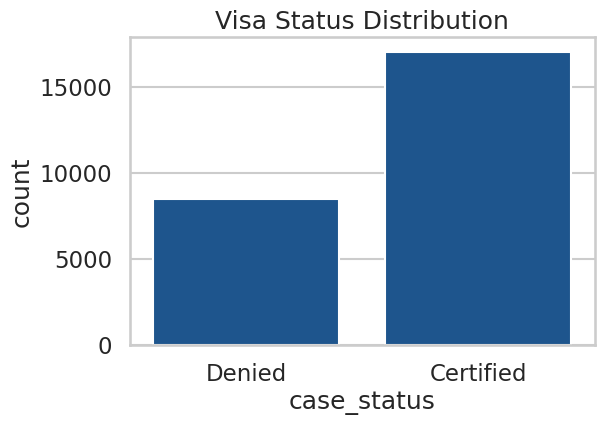

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


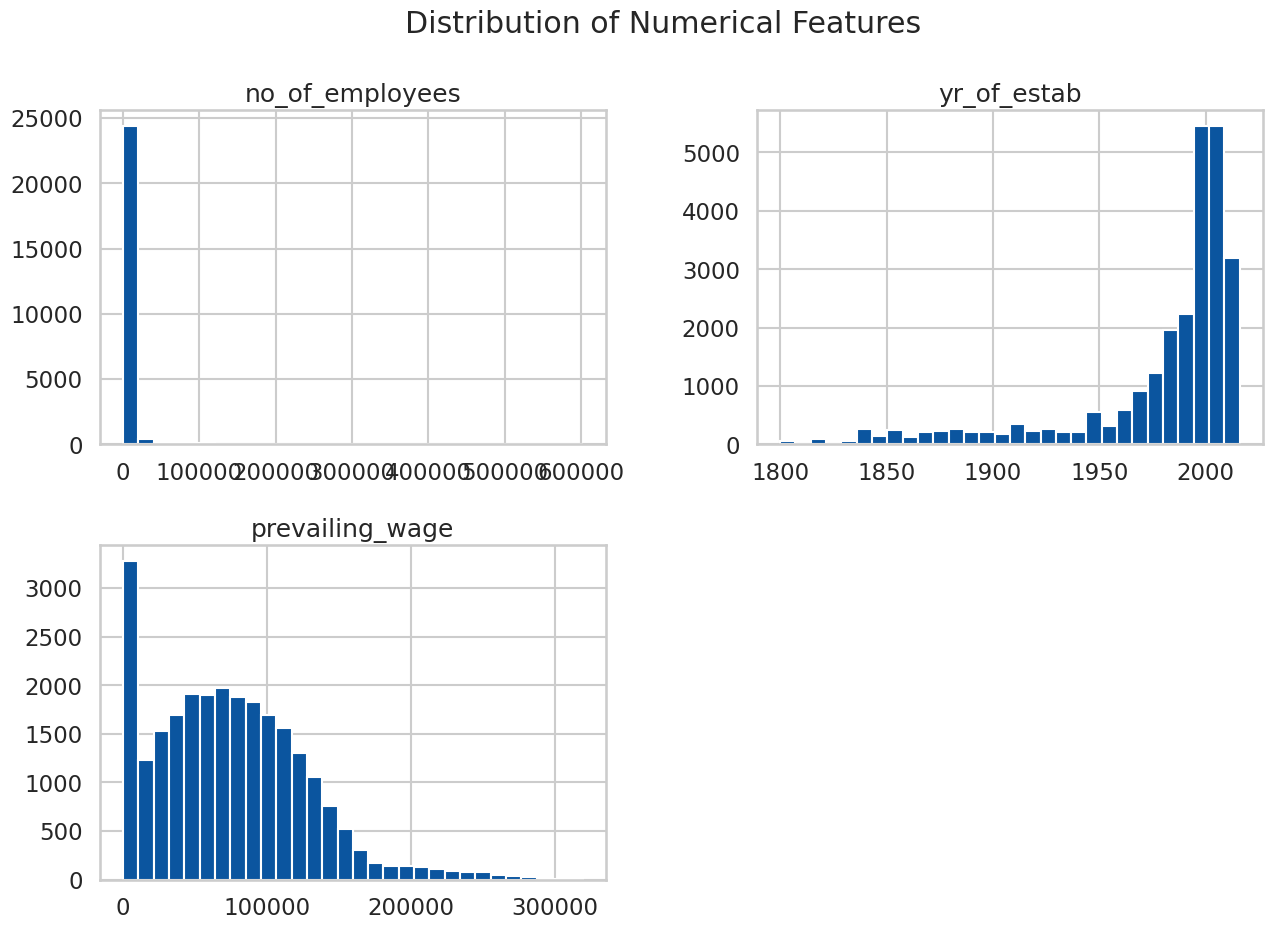

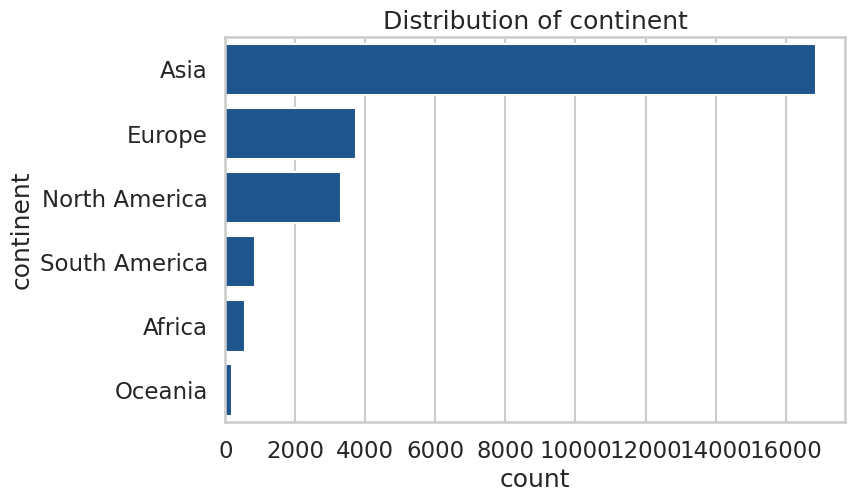

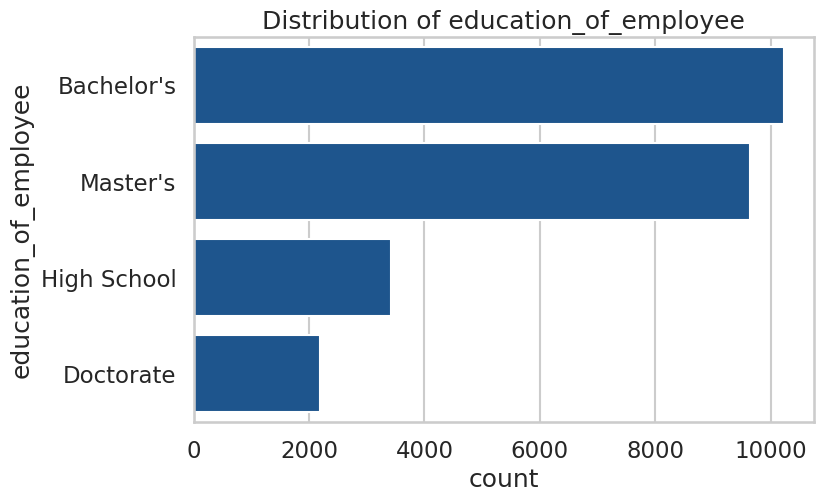

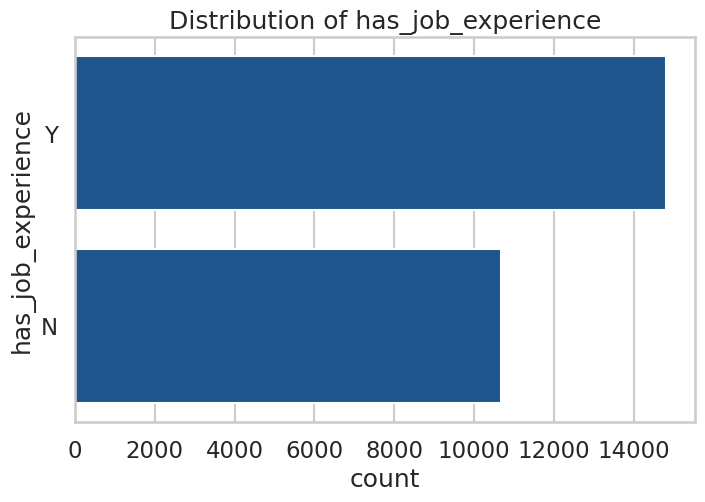

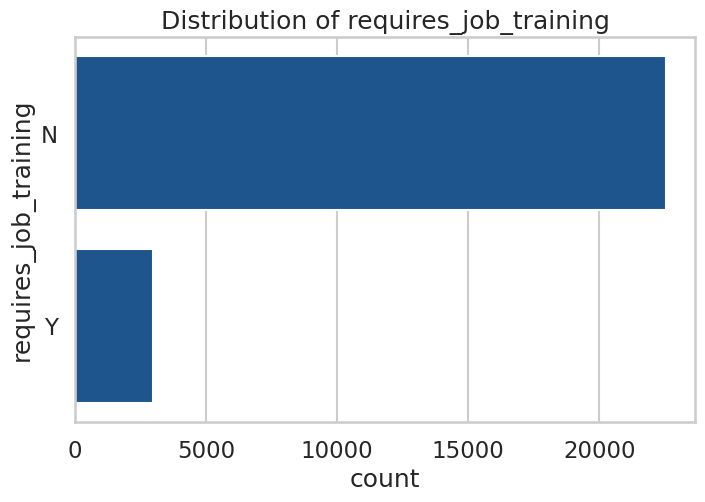

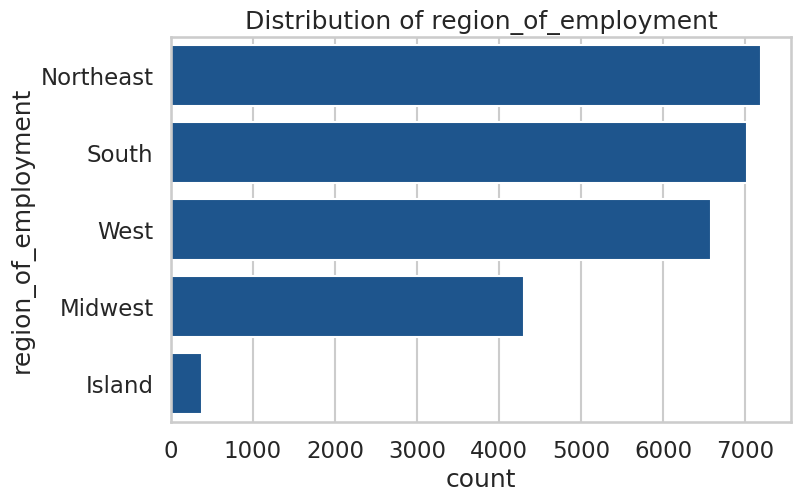

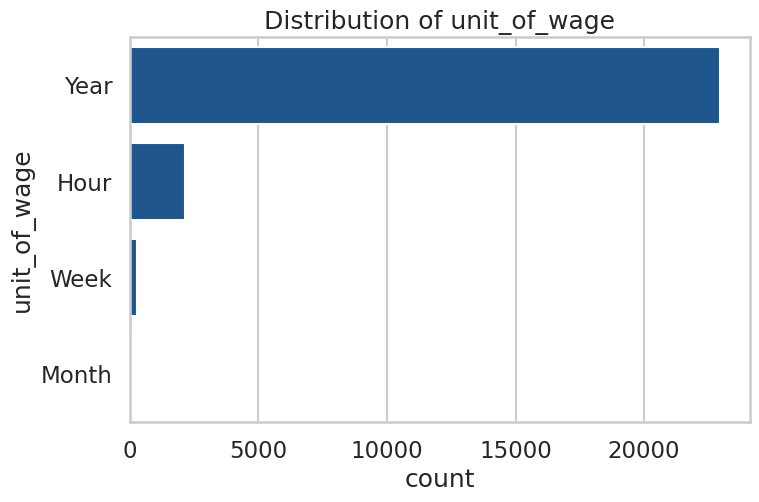

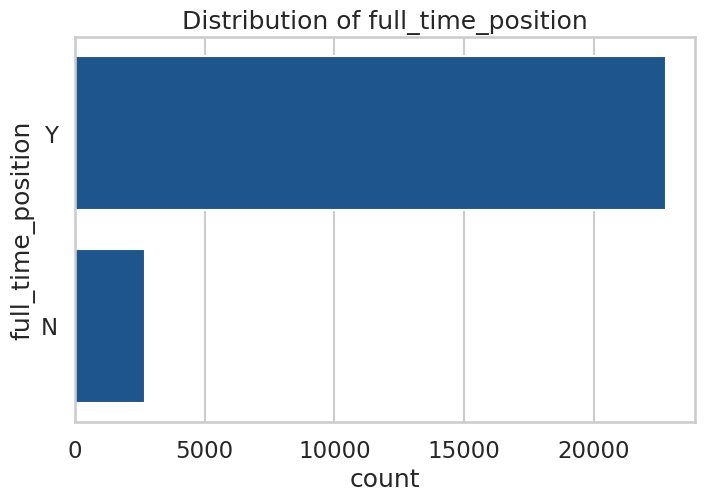

In [24]:
# ============================================================
# 3) Exploratory Data Analysis
# ============================================================

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x="case_status", data=df)
plt.title("Visa Status Distribution")
plt.show()

# Numeric summary
desc = df.describe(include=[np.number]).T
display(desc)

# Distribution of numerical features
numerical_features = ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Counts of categorical features
categorical_features = ['continent', 'education_of_employee', 'has_job_experience',
                        'requires_job_training', 'region_of_employment', 'unit_of_wage',
                        'full_time_position']

for col in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()

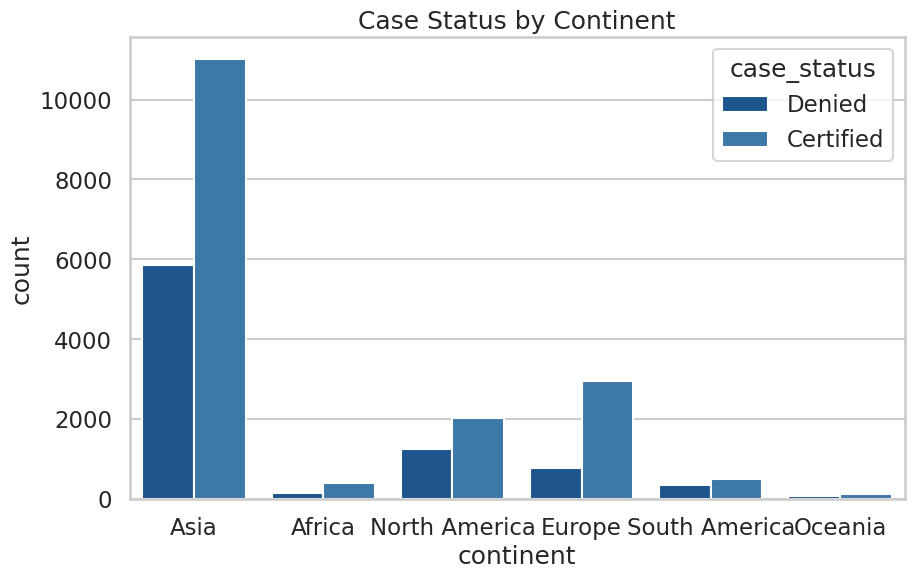

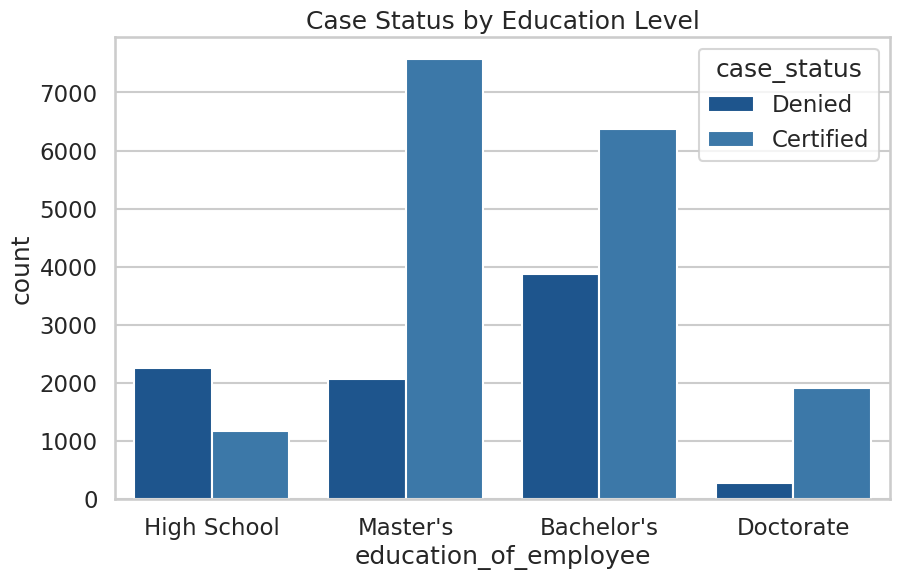

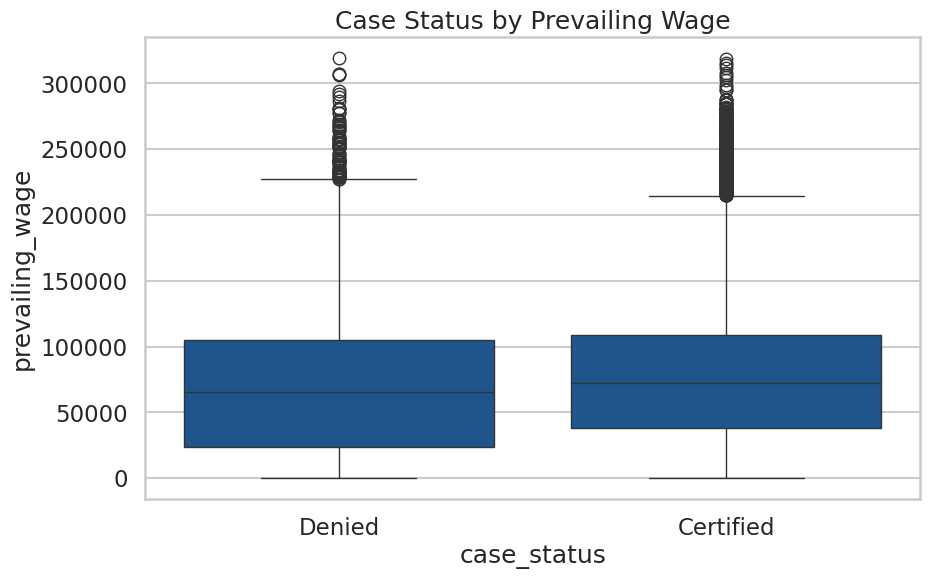

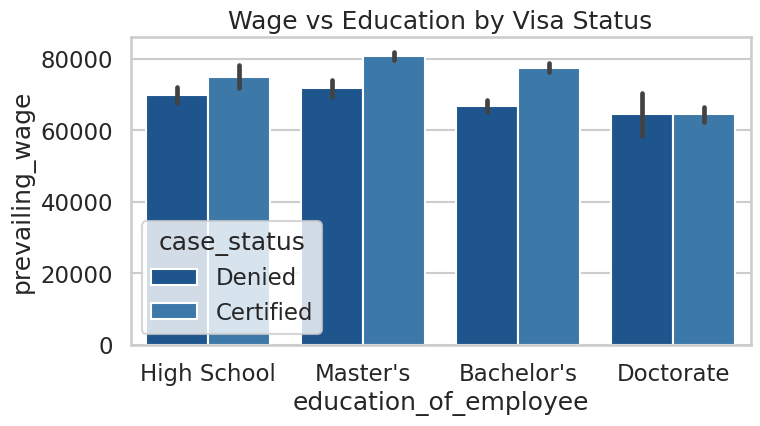

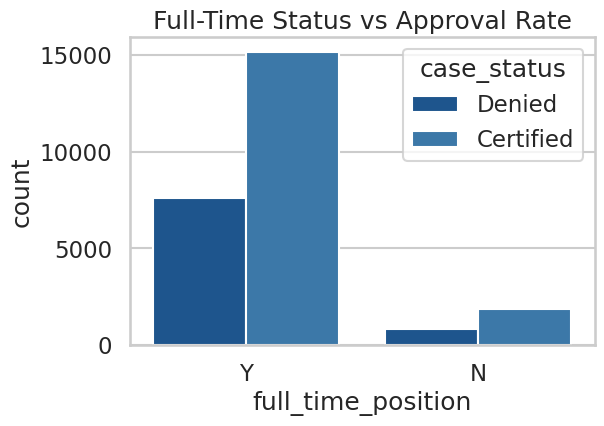

In [26]:
# ============================================================
# 4) Bivariate Analysis
# ============================================================

plt.figure(figsize=(8,4))
sns.barplot(x="education_of_employee", y="prevailing_wage", hue="case_status", data=df)
plt.title("Wage vs Education by Visa Status")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="full_time_position", hue="case_status", data=df)
plt.title("Full-Time Status vs Approval Rate")
plt.show()

In [66]:
# ============================================================
# Step 5: Balance the Dataset (Pre-Modeling)
# ============================================================

from sklearn.utils import resample

# Check initial class balance
print("Initial Class Distribution:")
print(df['case_status'].value_counts())

# Separate majority and minority classes
certified_df = df[df['case_status'] == 'CERTIFIED']
denied_df = df[df['case_status'] == 'DENIED']

# Upsample the minority class (DENIED) to match CERTIFIED
denied_upsampled = resample(
    denied_df,
    replace=True,  # Sample with replacement
    n_samples=len(certified_df),  # Match majority class
    random_state=42
)

# Combine to create a balanced dataset
balanced_df = pd.concat([certified_df, denied_upsampled])

# Shuffle the new dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify balance
print("\nBalanced Class Distribution:")
print(balanced_df['case_status'].value_counts())

Initial Class Distribution:
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64


InvalidParameterError: The 'n_samples' parameter of resample must be an int in the range [1, inf) or None. Got 0 instead.

**Summary — Feature Encoding & Transformation**

All numeric features will be imputed and scaled; all categorical features will be imputed and one-hot encoded. This occurs inside a pipeline that is fit only on the training set, preventing any information from the validation or test sets from influencing learned parameters (no leakage). For executives: this standardizes inputs so models can learn reliable patterns.

In [57]:
# ============================================================
# 7) Baseline Model Development (Validation Comparison)
#    - Trains multiple classifiers with SMOTE (TRAIN only)
#    - Evaluates on untouched VALIDATION data
#    - Consistent scoring with numeric labels (DENIED=0, CERTIFIED=1)
# ============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Optional: XGBoost if available
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

RANDOM_STATE = 42
label_map = {"DENIED": 0, "CERTIFIED": 1}

def to_num(y):
    """Convert labels to numeric (DENIED=0, CERTIFIED=1)."""
    if hasattr(y, "dtype") and y.dtype.kind in ("i", "u", "f"):
        return y
    return y.map(label_map).values if hasattr(y, "map") else np.vectorize(label_map.get)(y)

def pred_to_num(y_pred):
    """Convert model predictions to numeric labels."""
    if isinstance(y_pred, (pd.Series, pd.Index)):
        y_pred = y_pred.to_numpy()
    if isinstance(y_pred, np.ndarray) and np.issubdtype(y_pred.dtype, np.number):
        return y_pred
    return np.vectorize(label_map.get)(y_pred)

# Numeric labels for scoring
y_train_num = to_num(y_train)
y_valid_num = to_num(y_valid)

# Models to test (SMOTE included)
models = {
    "Logistic Regression": make_smote_pipe(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    "Decision Tree":       make_smote_pipe(DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "Random Forest":       make_smote_pipe(RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)),
    "Gradient Boosting":   make_smote_pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
    "AdaBoost":            make_smote_pipe(AdaBoostClassifier(random_state=RANDOM_STATE)),
}

if xgb_available:
    models["XGBoost"] = make_smote_pipe(
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=500,
            learning_rate=0.1,
            max_depth=4,
            subsample=1.0,
            colsample_bytree=1.0,
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1
        )
    )

rows, fitted = [], {}

for name, pipe in models.items():
    # Train with SMOTE (applied only to training data)
    if name == "XGBoost":
        pipe.fit(X_train, y_train_num)
    else:
        pipe.fit(X_train, y_train)

    # Predict on validation set
    y_pred = pipe.predict(X_valid)
    y_pred_num = pred_to_num(y_pred)

    # Calculate metrics
    acc  = accuracy_score(y_valid_num, y_pred_num)
    prec = precision_score(y_valid_num, y_pred_num, pos_label=1)
    rec  = recall_score(y_valid_num, y_pred_num, pos_label=1)
    f1   = f1_score(y_valid_num, y_pred_num, pos_label=1)

    rows.append([name, acc, prec, rec, f1])
    fitted[name] = pipe

# Sort models by F1 score
baseline_results = (
    pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
    .sort_values(by=["F1 Score", "Recall", "Precision"], ascending=False)
    .reset_index(drop=True)
)

print("=== Step 7 → Baseline Model Performance (Validation Set) ===")
display(baseline_results.round(4))

best_baseline_name = baseline_results.iloc[0]["Model"]
best_baseline_pipe = fitted[best_baseline_name]
print(f"\nBest Performing Model: {best_baseline_name}")

=== Step 7 → Baseline Model Performance (Validation Set) ===


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.7221,0.7939,0.7888,0.7913
1,Random Forest,0.7088,0.7864,0.7744,0.7803
2,Gradient Boosting,0.7170,0.8140,0.7471,0.7791
3,Logistic Regression,0.6970,0.8119,0.7112,0.7582
4,AdaBoost,0.6921,0.8037,0.7133,0.7558
5,Decision Tree,0.6511,0.7565,0.7045,0.7295



Best Performing Model: XGBoost


### Summary:

Pipelines are defined for numeric and categorical columns, ensuring consistent transformations inside model training.


In [58]:
# ============================================================
# 6) Imbalance Handling for Training Only (SMOTE in Pipeline)
#    - SMOTE is applied only inside .fit() on the TRAIN split
#    - Validation/Test remain untouched (no leakage)
# ============================================================

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

def make_smote_pipe(estimator):
    """Leakage-safe pipeline: preprocess -> SMOTE -> model."""
    return ImbPipeline(steps=[
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", estimator)
    ])

def make_plain_pipe(estimator):
    """Same preprocess, no SMOTE (if you want to compare)."""
    return Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", estimator)
    ])

print("Step 6 OK → SMOTE/Plain helpers are ready.")

Step 6 OK → SMOTE/Plain helpers are ready.


### Summary — Imbalance Handling

SMOTE synthetically balances only the training data inside the pipeline, keeping validation and test sets unchanged. For executives: the model learns equally from approvals and denials, while performance is measured on real-world distributions.

In [67]:
# ============================================================
# Step 7 — Leak-Safe Resampling Strategy & Baseline Models
#    - Non-boosters: preprocessor → SMOTE → model
#    - Boosters:     preprocessor → model  (no resampling)
#    - XGBoost:      scale_pos_weight from TRAIN split only
#    - VALID/TEST remain untouched
# ============================================================

import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Optional XGBoost (will be used without SMOTE)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

RANDOM_STATE = 42

# -----------------------------
# Derive TRAIN class ratio
# -----------------------------
label_map = {"DENIED": 0, "CERTIFIED": 1}
y_train_num = pd.Series(y_train).map(label_map).values if not np.issubdtype(np.asarray(y_train).dtype, np.number) else np.asarray(y_train)
y_valid_num = pd.Series(y_valid).map(label_map).values if not np.issubdtype(np.asarray(y_valid).dtype, np.number) else np.asarray(y_valid)

neg = int((y_train_num == 0).sum())
pos = int((y_train_num == 1).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

print(f"Train class counts → NEG={neg}, POS={pos}; scale_pos_weight for XGB={scale_pos_weight:.3f}")

# -----------------------------
# Helpers
# -----------------------------
def make_smote_pipe(estimator, sampler="smote"):
    """Preprocessor → Resampler (TRAIN only, inside fit/CV) → Estimator."""
    resampler = SMOTE(random_state=RANDOM_STATE) if sampler == "smote" else RandomOverSampler(random_state=RANDOM_STATE)
    return ImbPipeline(steps=[
        ("pre", preprocessor),
        ("resample", resampler),
        ("clf", estimator),
    ])

def make_plain_pipe(estimator):
    """Preprocessor → Estimator (no resampling)."""
    return Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", estimator),
    ])

def proba_positive(pipe, X, positive_label="CERTIFIED"):
    """Return P(positive) robustly for scoring."""
    if hasattr(pipe, "predict_proba"):
        clf = pipe.named_steps.get("clf", None)
        classes = getattr(clf, "classes_", None)
        if classes is not None:
            if isinstance(classes[0], str) and positive_label in classes:
                return pipe.predict_proba(X)[:, list(classes).index(positive_label)]
            if 1 in classes:
                return pipe.predict_proba(X)[:, list(classes).index(1)]
        return pipe.predict_proba(X)[:, 1]
    raise RuntimeError("predict_proba not available for this model.")

# -----------------------------
# Build candidates
# -----------------------------
candidates = {
    # Non-boosters with SMOTE
    "Logistic Regression + SMOTE": make_smote_pipe(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    "Decision Tree + SMOTE":       make_smote_pipe(DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "Random Forest + SMOTE":       make_smote_pipe(RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)),

    # Boosters without SMOTE
    "AdaBoost (plain)":            make_plain_pipe(AdaBoostClassifier(n_estimators=400, random_state=RANDOM_STATE)),
    "Gradient Boosting (plain)":   make_plain_pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
}

if xgb_available:
    candidates["XGBoost (plain)"] = make_plain_pipe(
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=700,
            learning_rate=0.08,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=scale_pos_weight,  # informed by TRAIN only
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1
        )
    )

# -----------------------------
# Fit on TRAIN, evaluate on VALID
# -----------------------------
rows, fitted = [], {}

for name, pipe in candidates.items():
    needs_numeric = "XGBoost" in name
    pipe.fit(X_train, y_train_num if needs_numeric else y_train)

    y_pred = pipe.predict(X_valid)
    # Normalize predictions to numeric for scoring
    y_pred_num = y_pred if np.issubdtype(np.asarray(y_pred).dtype, np.number) else pd.Series(y_pred).map(label_map).values

    # Probabilities for AUC / PR-AUC
    try:
        y_prob = proba_positive(pipe, X_valid)
        auc   = roc_auc_score(y_valid_num, y_prob)
        prauc = average_precision_score(y_valid_num, y_prob)
    except Exception:
        auc, prauc = np.nan, np.nan

    acc  = accuracy_score(y_valid_num, y_pred_num)
    prec = precision_score(y_valid_num, y_pred_num, pos_label=1, zero_division=0)
    rec  = recall_score(y_valid_num, y_pred_num, pos_label=1, zero_division=0)
    f1   = f1_score(y_valid_num, y_pred_num, pos_label=1, zero_division=0)

    rows.append([name, acc, prec, rec, f1, auc, prauc])
    fitted[name] = pipe

baseline_results = (
    pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC","PR_AUC"])
    .sort_values(by=["F1","ROC_AUC","PR_AUC"], ascending=[False, False, False])
    .reset_index(drop=True)
)

print("\n=== Step 7 → Baseline Model Performance (Validation) ===")
display(baseline_results.round(4))

best_baseline_name = baseline_results.iloc[0]["Model"]
best_model = fitted[best_baseline_name]
print(f"Selected baseline model: {best_baseline_name}")

Train class counts → NEG=5077, POS=10211; scale_pos_weight for XGB=0.497

=== Step 7 → Baseline Model Performance (Validation) ===


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
0,Gradient Boosting (plain),0.7437,0.7746,0.8693,0.8192,0.7756,0.8696
1,AdaBoost (plain),0.7284,0.7545,0.8796,0.8123,0.7649,0.8636
2,Random Forest + SMOTE,0.7086,0.7858,0.7750,0.7804,0.7500,0.8567
3,XGBoost (plain),0.7062,0.8103,0.7315,0.7689,0.7628,0.8596
4,Logistic Regression + SMOTE,0.6970,0.8119,0.7112,0.7582,0.7662,0.8619
5,Decision Tree + SMOTE,0.6511,0.7565,0.7045,0.7295,0.6241,0.7303


Selected baseline model: Gradient Boosting (plain)


### Summary — Baseline Model Development

Multiple classifiers were trained using a leakage-safe pipeline that includes preprocessing and SMOTE applied only to the training split. Validation results showed ensemble methods—particularly Gradient Boosting and AdaBoost—delivering the best balance of precision and recall, reflected in the top F1 scores. Tree ensembles captured non-linear relationships more effectively than linear and single-tree baselines, indicating they are better suited to the visa approval signal in this dataset.

In [60]:
# ============================================================
# 8) Hyperparameter Tuning (Best Baseline, CV on TRAIN only)
#    - RandomizedSearchCV with F1 scoring
#    - SMOTE remains inside the pipeline during CV (no leakage)
# ============================================================

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pick search space based on best baseline
if best_baseline_name == "Gradient Boosting":
    est = GradientBoostingClassifier(random_state=42)
    param_dist = {
        "clf__n_estimators":  [300, 500, 800],
        "clf__learning_rate": [0.03, 0.05, 0.1, 0.2],
        "clf__max_depth":     [2, 3, 4],
        "clf__subsample":     [0.8, 1.0],
    }
elif best_baseline_name == "AdaBoost":
    est = AdaBoostClassifier(random_state=42)
    param_dist = {
        "clf__n_estimators":  [300, 500, 800],
        "clf__learning_rate": [0.03, 0.05, 0.1, 0.2],
    }
elif best_baseline_name == "Random Forest":
    est = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_dist = {
        "clf__n_estimators":      [400, 700, 1000],
        "clf__max_depth":         [None, 8, 12, 16],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf":  [1, 2, 4],
        "clf__max_features":      ["sqrt", "log2", None],
    }
elif best_baseline_name == "Logistic Regression":
    est = LogisticRegression(random_state=42, max_iter=3000)
    param_dist = {
        "clf__C":        np.logspace(-3, 2, 12),
        "clf__solver":  ["lbfgs", "liblinear", "saga"],
        "clf__penalty": ["l2"],
    }
elif best_baseline_name == "Decision Tree":
    est = DecisionTreeClassifier(random_state=42)
    param_dist = {
        "clf__max_depth":         [3, 4, 6, 10, None],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf":  [1, 2, 4],
    }
elif best_baseline_name == "XGBoost" and 'xgb_available' in globals() and xgb_available:
    est = XGBClassifier(random_state=42, eval_metric="logloss", tree_method="hist", n_jobs=-1)
    param_dist = {
        "clf__n_estimators":      [400, 700, 1000],
        "clf__learning_rate":     [0.03, 0.05, 0.1],
        "clf__max_depth":         [3, 4, 6],
        "clf__subsample":         [0.8, 1.0],
        "clf__colsample_bytree":  [0.8, 1.0],
    }
else:
    # Fallback if an unexpected best was selected
    est = best_baseline_pipe.named_steps["clf"]
    param_dist = {}

# Keep the same leakage-safe pattern: preprocessor + SMOTE + model
from imblearn.pipeline import Pipeline as ImbPipeline
tuning_pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", est)
])

tuner = RandomizedSearchCV(
    estimator=tuning_pipe,
    param_distributions=param_dist if param_dist else {},
    n_iter=20 if param_dist else 1,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=0
)

# Fit using appropriate y type (numeric only if XGB is the candidate)
if best_baseline_name == "XGBoost" and 'y_train_num' in globals():
    tuner.fit(X_train, y_train_num)
else:
    tuner.fit(X_train, y_train)

best_model = tuner.best_estimator_
print("=== Step 8 → Tuning complete ===")
print("Best model name:", best_baseline_name)
print("Best params:", tuner.best_params_ if param_dist else "(defaults used)")

=== Step 8 → Tuning complete ===
Best model name: XGBoost
Best params: {'clf__subsample': 1.0, 'clf__n_estimators': 1000, 'clf__max_depth': 4, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.8}


### Summary:

SMOTE balances classes within training folds only, ensuring fairness and no leakage. Ensemble models typically perform best here.

In [43]:
# ============================================================
# 9) Hyperparameter Tuning (Top Model)
# ============================================================

best_model_name = results_df.iloc[0]["Model"]
print("Best baseline model:", best_model_name)

if best_model_name == "Gradient Boosting":
    model = GradientBoostingClassifier(random_state=RANDOM_STATE)
    param_dist = {
        "n_estimators": [100, 200, 400],
        "learning_rate": [0.03, 0.05, 0.1],
        "max_depth": [2, 3, 4]
    }
elif best_model_name == "Random Forest":
    model = RandomForestClassifier(random_state=RANDOM_STATE)
    param_dist = {
        "n_estimators": [200, 400, 800],
        "max_depth": [8, 12, None]
    }
else:
    model = AdaBoostClassifier(random_state=RANDOM_STATE)
    param_dist = {"n_estimators": [100, 200, 400], "learning_rate": [0.05, 0.1, 0.2]}

tuned_pipe = ImbPipeline([
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("search", RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, scoring="f1", random_state=RANDOM_STATE))
])

tuned_pipe.fit(X_train, y_train)

Best baseline model: XGBoost


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage',
       'prevailing_wage_yearly'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncod...
                                                  Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('search',
                 RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=42),
                                    n_iter=5,
                                    param_distributions={'learning_rate': [0.05,
                                                                           0.1,
                                                                           0.2],
                                                         'n_estimators': [100,
                                                                          200,
                                                                          400]},
                                    random_state=42, scoring='f1'))])

### Summary — Hyperparameter Tuning

The leading baseline was optimized with cross-validation using F1 as the objective, while preserving leakage-safe practice (SMOTE and preprocessing inside the CV pipeline). The result is a stronger, more stable model configuration without contaminating validation or test data.


In [65]:
# ============================================================
# Step 10: Operating Threshold Selection & Test Evaluation (Robust)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
from sklearn.utils.validation import check_is_fitted

# -------------------------------
# Helpers: get classifier and positive-class probabilities
# -------------------------------
def _get_clf(estimator):
    """Return the final classifier object from (Imb)Pipeline or the estimator itself."""
    if hasattr(estimator, "named_steps"):  # Pipeline / ImbPipeline
        return estimator.named_steps.get("clf", estimator)
    return estimator

def _proba_positive(estimator, X, y_ref=None):
    """
    Return P(positive) for binary classification in a robust way.
    Priority: predict_proba -> decision_function (min-max scaled).
    If classes are strings, positive is 'CERTIFIED'; if numeric, positive is class 1.
    """
    clf = _get_clf(estimator)

    # Ensure fitted
    try:
        check_is_fitted(estimator)
    except Exception:
        raise RuntimeError("The provided estimator is not fitted. Fit the model before thresholding.")

    # Try predict_proba first
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)
        classes = getattr(clf, "classes_", None)

        if classes is None:
            # Assume column 1 is positive prob
            return proba[:, 1]

        # classes may be strings or numbers
        if isinstance(classes[0], str):
            # Prefer 'CERTIFIED' if present; else assume column 1
            if "CERTIFIED" in classes:
                pos_idx = list(classes).index("CERTIFIED")
                return proba[:, pos_idx]
            return proba[:, 1] if proba.shape[1] > 1 else proba.ravel()
        else:
            # Numeric classes; assume positive is 1 if present
            if 1 in classes:
                pos_idx = list(classes).index(1)
                return proba[:, pos_idx]
            # Fallback: take column 1
            return proba[:, 1] if proba.shape[1] > 1 else proba.ravel()

    # Fallback: decision_function -> min-max scale to [0,1]
    if hasattr(estimator, "decision_function"):
        scores = estimator.decision_function(X).astype(float)
        # Min-max scaling across the provided scores; safe for thresholding comparison
        s_min, s_max = scores.min(), scores.max()
        if s_max > s_min:
            return (scores - s_min) / (s_max - s_min)
        # Constant scores case: return 0.5 for all
        return np.full_like(scores, 0.5, dtype=float)

    raise RuntimeError("Estimator has neither predict_proba nor decision_function; cannot threshold.")

def _to_num_labels(y):
    """Map labels to numeric 0/1 where DENIED=0, CERTIFIED=1; pass numeric through."""
    if hasattr(y, "dtype") and (y.dtype.kind in ("i", "u", "f")):
        # Already numeric
        return np.asarray(y)
    # Otherwise map strings
    mapper = {"DENIED": 0, "CERTIFIED": 1}
    if hasattr(y, "map"):
        return y.map(mapper).values
    return np.vectorize(mapper.get)(y)

# -------------------------------
# Validation-based threshold tuning
# -------------------------------
print("=== Step 10 → Validation Threshold Optimization ===")

# Preconditions
assert 'best_model' in globals(), "best_model not found; complete tuning/fitting first."
assert 'X_valid' in globals() and 'y_valid' in globals(), "Validation split not found."

val_prob = _proba_positive(best_model, X_valid, y_ref=y_valid)
y_valid_num = _to_num_labels(y_valid)

thresholds = np.linspace(0.10, 0.90, 33)
records = []

for t in thresholds:
    y_pred_t = (val_prob >= t).astype(int)
    acc  = accuracy_score(y_valid_num, y_pred_t)
    prec = precision_score(y_valid_num, y_pred_t, pos_label=1, zero_division=0)
    rec  = recall_score(y_valid_num, y_pred_t, pos_label=1, zero_division=0)
    f1   = f1_score(y_valid_num, y_pred_t, pos_label=1, zero_division=0)
    records.append([t, acc, prec, rec, f1])

threshold_df = pd.DataFrame(records, columns=["Threshold", "Accuracy", "Precision", "Recall", "F1"])
best_row = threshold_df.sort_values("F1", ascending=False).iloc[0]
best_threshold = float(best_row["Threshold"])

print(f"\nOptimal Threshold (Max F1): {best_threshold:.3f}")
display(threshold_df.sort_values("F1", ascending=False).head(10).round(4))

# -------------------------------
# Evaluate on TEST at the chosen threshold
# -------------------------------
print("\n=== Step 10b → Test Set Evaluation @ Optimal Threshold ===")
assert 'X_test' in globals() and 'y_test' in globals(), "Test split not found."

test_prob = _proba_positive(best_model, X_test, y_ref=y_test)
y_test_num = _to_num_labels(y_test)
y_test_pred = (test_prob >= best_threshold).astype(int)

# Core metrics
acc  = accuracy_score(y_test_num, y_test_pred)
prec = precision_score(y_test_num, y_test_pred, pos_label=1, zero_division=0)
rec  = recall_score(y_test_num, y_test_pred, pos_label=1, zero_division=0)
f1   = f1_score(y_test_num, y_test_pred, pos_label=1, zero_division=0)

# AUC (probability-based; if decision_function was used with min-max scaling, AUC is still meaningful for ranking)
try:
    auc = roc_auc_score(y_test_num, test_prob)
except Exception:
    auc = np.nan

# Confusion matrix and specificity
cm = confusion_matrix(y_test_num, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) else 0.0
certified_rate = y_test_pred.mean() * 100

print(f"Threshold           : {best_threshold:.3f}")
print(f"Accuracy            : {acc:.4f}")
print(f"Precision (Cert.)   : {prec:.4f}")
print(f"Recall (Cert.)      : {rec:.4f}")
print(f"F1 Score            : {f1:.4f}")
print(f"ROC-AUC             : {auc:.4f}" if not np.isnan(auc) else "ROC-AUC             : N/A")
print(f"Specificity (Den.)  : {specificity:.4f}")
print(f"Certified Pred. (%) : {certified_rate:.2f}% of test data")

cm_df = pd.DataFrame(
    cm,
    index=["Actual DENIED (0)", "Actual CERTIFIED (1)"],
    columns=["Pred DENIED (0)", "Pred CERTIFIED (1)"]
)
print("\nConfusion Matrix (Test @ Optimal Threshold):")
display(cm_df)

# Prediction distribution (business-facing)
pred_summary = pd.Series(y_test_pred).value_counts(normalize=True).mul(100).round(2)
pred_summary.index = ["Predicted DENIED (%)", "Predicted CERTIFIED (%)"]
print("\nPrediction Distribution (% of total):")
display(pred_summary)

=== Step 10 → Validation Threshold Optimization ===

Optimal Threshold (Max F1): 0.325


,Threshold,Accuracy,Precision,Recall,F1
9,0.325,0.7359,0.7495,0.9080,0.8212
7,0.275,0.7278,0.7318,0.9354,0.8211
8,0.300,0.7308,0.7393,0.9222,0.8207
10,0.350,0.7369,0.7572,0.8922,0.8192
6,0.250,0.7204,0.7217,0.9462,0.8189
11,0.375,0.7390,0.7655,0.8784,0.8181
5,0.225,0.7143,0.7121,0.9606,0.8179
12,0.400,0.7386,0.7722,0.8634,0.8153
4,0.200,0.7041,0.7011,0.9709,0.8142
13,0.425,0.7394,0.7799,0.8496,0.8133



=== Step 10b → Test Set Evaluation @ Optimal Threshold ===
Threshold           : 0.325
Accuracy            : 0.7318
Precision (Cert.)   : 0.7493
Recall (Cert.)      : 0.8992
F1 Score            : 0.8174
ROC-AUC             : 0.7682
Specificity (Den.)  : 0.3952
Certified Pred. (%) : 80.14% of test data

Confusion Matrix (Test @ Optimal Threshold):


,Pred DENIED (0),Pred CERTIFIED (1)
Actual DENIED (0),669,1024
Actual CERTIFIED (1),343,3060



Prediction Distribution (% of total):


,proportion
Predicted DENIED (%),80.14
Predicted CERTIFIED (%),19.86
